
# MVP: *Machine Learning & Analytics*

Trabalho desenvolvido para o Curso de Pós-Graduação em Ciência de Dados e Analytics da PUC Rio.

**Autora:** Léa Juliane Smarzaro C. Caseira  

**Data:** 28/09/2025

**Matrícula:** 40530010056

**Dataset:**  [Wine Reviews Data](https://www.kaggle.com/datasets/samuelmcguire/wine-reviews-data/data)

---



## 1. Escopo, objetivo e definição do problema

O mercado de vinhos no Brasil tem apresentado um crescimento notável nos últimos anos impulsionado por novos hábitos de consumo, pela diversificação de rótulos e pelo amadurecimento dos consumidores. Aproveitando essa oportunidade de negócio, um revendedor precisa aprimorar sua capacidade de estimar o preço ideal de cada vinho utilizando suas características como base para definir valores atrativos e competitivos.

Dessa forma, o objetivo desse trabalho é desenvolver uma solução de aprendizado de máquina **supervionado** para estimar o preço de um vinho de acordo com suas características.

Para isso, utilizaremos um conjunto de dados de avaliações de vinhos retiradas de páginas web e, portanto, será necessária uma etapa tratamento e limpeza dos dados para que estes possam ser usados para a construção e treinamento do modelo.

Adicionalmente, vamos avaliar a utilização de algoritmos de **regressão** para a resolução do problema.








## 2. Reprodutibilidade e ambiente

In [1]:
# === Setup básico e reprodutibilidade ===
import os, random, time, sys, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import seaborn as sns
import joblib

from kagglehub import KaggleDatasetAdapter
from google.colab import userdata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,make_scorer,
confusion_matrix,mean_absolute_error, mean_squared_error,
r2_score,silhouette_score)
from sklearn.model_selection import cross_validate, KFold, RandomizedSearchCV
from lightgbm import LGBMRegressor
from scipy.stats import randint, uniform

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("Python:", sys.version.split()[0])
print("Seed global:", SEED)

Python: 3.12.11
Seed global: 42



### 2.1 Dependências

In [2]:
!pip install kagglehub[pandas-datasets]
!pip install -q scikit-learn imbalanced-learn xgboost lightgbm catboost optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 24.1 MB/s eta 0:00:00


### 2.2 Funções python


In [3]:
# Extrai as informações de pais, regiao e sub-regiao da variavel appellation
def extrair_partes(appellation: str):
    if pd.isna(appellation):
        return pd.Series([None, None, None])  # se for nulo

    partes = [p.strip() for p in appellation.split(",")]
    n = len(partes) - 1  # número de vírgulas

    if n == 4:
        # 5 partes: parte 5 = pais, parte 4 = regiao, parte 3 = sub-regiao
        return pd.Series([partes[2], partes[3], partes[4]], index=["subregiao", "regiao", "pais"])
    elif n == 3:
        # 4 partes: parte 4 = pais, parte 3 = regiao, parte 2 = sub-regiao
        return pd.Series([partes[1], partes[2], partes[3]], index=["subregiao", "regiao", "pais"])
    elif n == 2:
        # 3 partes: parte 3 = pais, parte 2 = regiao, parte 1 = sub-regiao
        return pd.Series([partes[0], partes[1], partes[2]], index=["subregiao", "regiao", "pais"])
    elif n == 1:
        # 2 partes: parte 2 = pais, parte 1 = regiao
        return pd.Series([None, partes[0], partes[1]], index=["subregiao", "regiao", "pais"])
    else:
        return pd.Series([None, None, partes[0]], index=["subregiao", "regiao", "pais"])


# Calcula e retorna métricas de regressão
def evaluate_regression(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R²": r2}


## 3. Dados: carga, entendimento e qualidade

**- Origem dos dados**

Utilizaremos o conjunto de dados tabulares [Wine Reviews Data](https://www.kaggle.com/datasets/samuelmcguire/wine-reviews-data/data) que consiste em avaliações de vinhos retiradas de páginas web. O dataset possui aproximadamente 320 mil amostras e 11 atributos.

**- Dicionário de variáveis**
- Wine: Nome do vinho
- Winery: Nome da vinícula
- Category: Tipo de vinho (tinto, branco, espumante, rosé, porto, fortificado e de sobremesa)
- Designation: Identificação do vinho. É uma combinação de outras características, como tipo de vinho, tipo de uva e região de origem.
- Varietal: Tipo de uva
- Appellation: Região de origem
- Alcohol: Percentual de teor alcoólico
- Price: Preço da garrafa do vinho
- Rating: A nota que o revisor deu ao vinho
  - 80-84: Acima da média e bom
  - 85-89: Bom e muito bom
  - 90-94: Excelente e superior
  - 95-100: Extraordinário, excepcional e clássico
- Reviewer: Revisor
- Review: Revisão

**- Licença e ética**

O dataset está disponível publicamente no Kaggle sem restrições de uso comercial ou acadêmico. Além disso, não possui dados pessoais, sensíveis ou  que permitam a identificação individual, e, portanto, obedecendo à LGPD.

In [4]:
# === Carga dos dados ===
file_path = "wine.csv"
wine_reviews = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,"samuelmcguire/wine-reviews-data",file_path,)
wine_reviews.head()

100%|██████████| 42.3M/42.3M [00:00<00:00, 109MB/s]

Extracting zip of wine.csv...


,wine,winery,category,designation,varietal,appellation,alcohol,price,rating,reviewer,review
0,J. Lohr 2000 Hilltop Vineyard Cabernet Sauvign...,J. Lohr,Red,Hilltop Vineyard,Cabernet Sauvignon,"Paso Robles, Central Coast, California, US",NaN,$32,87,NaN,"Held back nearly five years, this Cab still ha..."
1,Antucura 2010 Pinot Noir (Vista Flores),Antucura,Red,NaN,Pinot Noir,"Vista Flores, Mendoza Province, Argentina",15%,$17,85,Michael Schachner,"Rubbery, bold and earthy on the nose, then ful..."
2,Quinta do Portal 1999 Quinta do Portal Reserva...,Quinta do Portal,Red,Quinta do Portal Reserva,"Red Blends, Red Blends","Douro, Portugal",NaN,NaN,90,Roger Voss,"Smoky, meaty aromas lead into perfumed fruit f..."
3,Tenuta di Ghizzano 2006 Il Ghizzano Red (Toscana),Tenuta di Ghizzano,Red,Il Ghizzano,"Red Blends, Red Blends","Toscana, Tuscany, Italy",13.5%,$18,86,NaN,The nose is rather neutral save for distant ar...
4,Tenuta San Francesco 2007 Tramonti White (Camp...,Tenuta San Francesco,White,Tramonti,White Blend,"Campania, Southern Italy, Italy",13.5%,$21,85,NaN,"This intriguing blend of Falanghina, Biancolel..."


In [5]:
# === Verificações iniciais ===
display(wine_reviews.sample(5))
print("\nFormato:", wine_reviews.shape)
print("\nTipos:")
print(wine_reviews.dtypes)
print("\nValores ausentes por coluna:")
print(wine_reviews.isna().sum())


,wine,winery,category,designation,varietal,appellation,alcohol,price,rating,reviewer,review
240046,Herdade de São Miguel 2012 Herdade da Pimenta ...,Herdade de São Miguel,Red,Herdade da Pimenta,Portuguese Red,"Alentejano, Portugal",14.5%,$18,90,Roger Voss,"This is a solid wine with herbal, minty aromas..."
322563,Fowles Wine 2018 Ladies who Shoot their Lunch ...,Fowles Wine,White,Ladies who Shoot their Lunch Wild Ferment,Chardonnay,"Victoria, Victoria, Australia",13.2%,$35,88,Christina Pickard,"This is a high solids, unmistakably Aussie Cha..."
143268,Terre di Talamo 2012 Tempo Riserva (Morellino...,Terre di Talamo,Red,Tempo Riserva,"Red Blends, Red Blends","Morellino di Scansano, Tuscany, Italy",14%,NaN,89,Kerin O’Keefe,"Made with 85% Sangiovese, 5% Alicante, 5% Cabe..."
123088,Pascal Jolivet 2010 Les Caillottes (Sancerre),Pascal Jolivet,White,Les Caillottes,Sauvignon Blanc,"Sancerre, Loire Valley, France",13%,NaN,90,Roger Voss,Old vines on a single parcel provide the base ...
20172,Château de Santenay 2014 Clos Philippe le Hard...,Château de Santenay,Red,Clos Philippe le Hardi,Pinot Noir,"Hautes Cotes de Beaune, Burgundy, France",13%,$30,89,Roger Voss,Philip the Bold was Duke of Burgundy in the 14...



Formato: (323237, 11)

Tipos:
wine           object
winery         object
category       object
designation    object
varietal       object
appellation    object
alcohol        object
price          object
rating          int64
reviewer       object
review         object
dtype: object

Valores ausentes por coluna:
wine               0
winery             0
category           0
designation    93545
varietal       21047
appellation     2607
alcohol        41021
price          23955
rating             0
reviewer       72162
review          1129
dtype: int64


Podemos verificar que o dataset possui 323.237 observações e 11 colunas, onde apenas o atributo 'Rating' é númerico e os demais são categóricos. As colunas 'designation', 'varietal', 'appellation', 'alcohol', 'price', 'reviewer' e 'review' possuem uma grande quantidade de nulos. Vamos tratar as colunas 'designation', 'appelation', 'reviewer' e 'review' substituindo os nulos por 'Nao identificado' e a coluna 'varietal' por 'Blend' que é uma mistura de tipos e uvas.

In [6]:
wine_reviews['designation'] = wine_reviews['designation'].fillna('Nao identificado')
wine_reviews['varietal'] = wine_reviews['varietal'].fillna('Blend')
wine_reviews['appellation'] = wine_reviews['appellation'].fillna('Nao identificado')
wine_reviews['reviewer'] =  wine_reviews['reviewer'].fillna('Nao identificado')
wine_reviews['review'] = wine_reviews['review'].fillna('Nao identificado')
display(wine_reviews.tail())

,wine,winery,category,designation,varietal,appellation,alcohol,price,rating,reviewer,review
323232,Maddalena 2017 Rosé (Paso Robles),Maddalena,Rose,Nao identificado,Rosé,"Paso Robles, Central Coast, California, US",12.5%,$18,87,Matt Kettmann,"Candied raspberry, cranberry, orange juice and..."
323233,Toscolo 2015 Vernaccia di San Gimignano,Toscolo,White,Nao identificado,"Vernaccia, Italian White","Vernaccia di San Gimignano, Tuscany, Italy",12.5%,$11,87,Kerin O’Keefe,"Aromas of white spring flower, yellow pear and..."
323234,Domaine G. Metz 2017 Pinot Blanc (Alsace),Domaine G. Metz,White,Nao identificado,Pinot Blanc,"Alsace, Alsace, France",13%,$20,90,Anne Krebiehl MW,"A tinge of earth clings to the ripe, almost ju..."
323235,Huston 2019 Chicken Dinner Red (Idaho),Huston,Red,Chicken Dinner,"Red Blends, Red Blends","Idaho, Idaho, US",14.3%,$18,87,Sean P. Sullivan,"Fruit-forward aromas of plum, huckleberry and ..."
323236,La Selva 2008 Maremma,La Selva,Red,Nao identificado,"Ciliegiolo, Italian White","Maremma, Tuscany, Italy",13.5%,$28,86,Nao identificado,Made from organically farmed Ciliegiolo (one o...


Para coluna 'alcohol' vamos excluir os valores nulos, remover o simbolo % e converter o formato para float.

In [7]:
wine_reviews.dropna(subset=['alcohol'], inplace=True)
wine_reviews['alcohol'] = wine_reviews['alcohol'].astype(str).str.replace('%','')
wine_reviews['alcohol'] = (wine_reviews['alcohol'].astype(float))
print(wine_reviews.dtypes);

wine            object
winery          object
category        object
designation     object
varietal        object
appellation     object
alcohol        float64
price           object
rating           int64
reviewer        object
review          object
dtype: object


In [8]:
wine_reviews[['alcohol']].describe().round(2)

,alcohol
count,282216.00
mean,13.79
std,25.84
min,0.50
25%,13.00
50%,13.50
75%,14.40
max,8333.00


Podemos perceber que existem valores muito acima do esperado, pois vinhos não possuem mais de 24% de teor alcoólico.

In [9]:
qtd_alcool_max = len(wine_reviews[wine_reviews['alcohol'] > 25])
print(f"\nQuantidade de vinhos com teor alcoolico acima do aceitável: {qtd_alcool_max }")
qtd_alcool_min = len(wine_reviews[wine_reviews['alcohol'] < 8])
print(f"\nQuantidade vinhos com baixo teor alcoolico: {qtd_alcool_min }")



Quantidade de vinhos com teor alcoolico acima do aceitável: 139

Quantidade vinhos com baixo teor alcoolico: 1149


Vamos remover esses registros que possuem o teor alcoólico acima de 25%, pois são valores acima do aceitável mesmo para os vinhos fortificados. Os vinhos com percentual alcoólico abaixo de 8% também possuem uma baixa representividade no dataset, contudo, não serão removidos, pois refletem a realidade.

In [10]:
wine_reviews.drop(wine_reviews.index[wine_reviews['alcohol']> 25], inplace=True)

Agora faremos o mesmo tratamento para a coluna 'price'.

In [11]:
# Remove o simbolo '$'
wine_reviews['price'] = wine_reviews['price'].str.replace('$','')

# Converte o tipo para float e os valores não numericos serão alterados para
# nulo.
wine_reviews['price'] = pd.to_numeric(wine_reviews['price'],errors='coerce')

# Remove os valores nulos
wine_reviews.dropna(subset=['price'], inplace=True)
print(wine_reviews.dtypes);

wine            object
winery          object
category        object
designation     object
varietal        object
appellation     object
alcohol        float64
price          float64
rating           int64
reviewer        object
review          object
dtype: object


In [12]:
display(wine_reviews.head())

,wine,winery,category,designation,varietal,appellation,alcohol,price,rating,reviewer,review
1,Antucura 2010 Pinot Noir (Vista Flores),Antucura,Red,Nao identificado,Pinot Noir,"Vista Flores, Mendoza Province, Argentina",15.0,17.0,85,Michael Schachner,"Rubbery, bold and earthy on the nose, then ful..."
3,Tenuta di Ghizzano 2006 Il Ghizzano Red (Toscana),Tenuta di Ghizzano,Red,Il Ghizzano,"Red Blends, Red Blends","Toscana, Tuscany, Italy",13.5,18.0,86,Nao identificado,The nose is rather neutral save for distant ar...
4,Tenuta San Francesco 2007 Tramonti White (Camp...,Tenuta San Francesco,White,Tramonti,White Blend,"Campania, Southern Italy, Italy",13.5,21.0,85,Nao identificado,"This intriguing blend of Falanghina, Biancolel..."
5,Las Positas 2011 Estate Barbera (Livermore Val...,Las Positas,Red,Estate,Barbera,"Livermore Valley, Central Coast, California, US",15.1,40.0,89,Virginie Boone,"This is a hefty Barbera, replete with dark, br..."
6,Krupp Brothers 2007 The Doctor Red (Napa Valley),Krupp Brothers,Red,The Doctor,"Red Blends, Red Blends","Napa Valley, Napa, California, US",15.1,60.0,92,Nao identificado,"An ambitious blend of Merlot, Tempranillo, Mal..."


Verificando os dados da coluna 'rating'.

In [13]:
wine_reviews[['rating']].describe().round(2)

,rating
count,260568.00
mean,88.56
std,3.17
min,80.00
25%,86.00
50%,88.00
75%,91.00
max,100.00


Vamos adicionar uma coluna ao dataset normalizando o atributo 'rating' da seguinte forma:

- 80-84: Bom
- 85-89: Muito bom
- 90-94: Excelente
- 95-100: Extraordinário

In [14]:
conditions= [
    (wine_reviews['rating'] >= 80) & (wine_reviews['rating'] <= 84),
    (wine_reviews['rating'] >= 85) & (wine_reviews['rating'] <= 89),
    (wine_reviews['rating'] >= 90) & (wine_reviews['rating'] <= 94),
    (wine_reviews['rating'] >= 95) & (wine_reviews['rating'] <= 100)
]
values = ['Bom','Muito bom','Excelente','Extraordinário']

wine_reviews['rating_normalized'] = np.select(conditions, values, default='')
display(wine_reviews.sample(5))

,wine,winery,category,designation,varietal,appellation,alcohol,price,rating,reviewer,review,rating_normalized
208260,Il Grappolo 2010 Brunello di Montalcino,Il Grappolo,Red,Nao identificado,Sangiovese,"Brunello di Montalcino, Tuscany, Italy",14.5,50.0,93,Kerin O’Keefe,"Aromas recall mature dark berry, stewed plum, ...",Excelente
250355,Vinha Paz 2014 Reserva Red (Dão),Vinha Paz,Red,Reserva,Portuguese Red,"Dão, Portugal",13.5,45.0,95,Roger Voss,This producer's vineyards are in the heart of ...,Extraordinário
85983,Casaloste 2007 Inversus Red (Toscana),Casaloste,Red,Inversus,"Red Blends, Red Blends","Toscana, Tuscany, Italy",13.5,38.0,89,Nao identificado,"This oak-aged Merlot, which includes 10% Sangi...",Muito bom
36841,Sonoma-Loeb 2013 Sauvignon Blanc (Sonoma County),Sonoma-Loeb,White,Nao identificado,Sauvignon Blanc,"Sonoma County, Sonoma, California, US",14.1,18.0,84,Virginie Boone,Sourced from both the Russian River and Alexan...,Bom
295762,Gloria Ferrer 2002 Rust Rock Terrace Pinot Noi...,Gloria Ferrer,Red,Rust Rock Terrace,Pinot Noir,"Carneros, Napa-Sonoma, California, US",13.5,40.0,85,Nao identificado,This is a good Pinot but it has some problems ...,Muito bom


Assim, finalizamos a limpeza e tratamento do dataset original e, então, iremos verificar o volume de dados tratados que serão utilizados nas etapas seguintes.

In [15]:
# === Verificações finais ===
display(wine_reviews.sample(5))
print("\nFormato:", wine_reviews.shape)
print("\nTipos:")
print(wine_reviews.dtypes)
print("\nValores ausentes por coluna:")
print(wine_reviews.isna().sum())

,wine,winery,category,designation,varietal,appellation,alcohol,price,rating,reviewer,review,rating_normalized
70768,Adanti 2007 Il Domenico (Montefalco Sagrantino),Adanti,Red,Il Domenico,"Sagrantino, Italian Red","Montefalco Sagrantino, Central Italy, Italy",15.0,55.0,91,Kerin O’Keefe,"Underbrush, black plum and balsamic notes lead...",Excelente
136750,Coli 2000 Montepulciano d'Abruzzo,Coli,Red,Nao identificado,"Montepulciano, Italian Red","Montepulciano d'Abruzzo, Central Italy, Italy",11.5,7.0,84,Nao identificado,"Starts off with peach, almond and cherry aroma...",Bom
2914,Carol Shelton 2019 Wild Thing Rendezvous Rosé ...,Carol Shelton,Rose,Wild Thing Rendezvous,Rosé,"Mendocino County, Mendocino County, California...",13.5,17.0,86,Jim Gordon,"A bright, deep-pink color and intense candied ...",Muito bom
307505,Dopff & Irion 2007 Pinot Gris (Alsace),Dopff & Irion,White,Nao identificado,Blend,"Alsace, Alsace, France",13.0,19.0,83,Nao identificado,"Opens with slightly funky cheese rind notes, t...",Bom
148962,August Briggs 2016 Pinot Noir (Russian River V...,August Briggs,Red,Nao identificado,Pinot Noir,"Russian River Valley, Sonoma, California, US",14.5,42.0,90,Virginie Boone,Juicy dark cherry and earthy black tea highlig...,Excelente



Formato: (260568, 12)

Tipos:
wine                  object
winery                object
category              object
designation           object
varietal              object
appellation           object
alcohol              float64
price                float64
rating                 int64
reviewer              object
review                object
rating_normalized     object
dtype: object

Valores ausentes por coluna:
wine                 0
winery               0
category             0
designation          0
varietal             0
appellation          0
alcohol              0
price                0
rating               0
reviewer             0
review               0
rating_normalized    0
dtype: int64


**- Conjunto de dados final**
- Estrutura:
  - A base possui estrutura tabular com 260.568 registros e 12 variáveis;
- Tipo dos dados:
  - Categóricos: 'wine', 'winery', 'category', 'designation', 'varietal', 'appellation', 'reviewer', 'review', 'rating_normalized';
  - Numéricos: 'alcohol', 'price'(**alvo**), 'rating';
- Qualidade:
  - A base de dados final não possui valores ausentes;



### 3.1 Análise exploratória resumida (EDA)

In [16]:
# === Verificações iniciais ===
wine_reviews.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
wine,260568,257495,Korbel NV Brut Sparkling (California),12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
winery,260568,24113,Williams Selyem,431,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,260568,7,Red,155525,NaN,NaN,NaN,NaN,NaN,NaN,NaN
designation,260568,67208,Nao identificado,74010,NaN,NaN,NaN,NaN,NaN,NaN,NaN
varietal,260568,848,Pinot Noir,28062,NaN,NaN,NaN,NaN,NaN,NaN,NaN
appellation,260568,1929,"Napa Valley, Napa, California, US",9011,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alcohol,260568.0,NaN,NaN,NaN,13.586848,1.231341,0.5,13.0,13.5,14.4,25.0
price,260568.0,NaN,NaN,NaN,35.649987,44.523578,3.0,17.0,26.0,44.0,8500.0
rating,260568.0,NaN,NaN,NaN,88.556035,3.168176,80.0,86.0,88.0,91.0,100.0
reviewer,260568,23,Nao identificado,52389,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Nesse projeto, as características 'wine', 'winery', 'designation', 'reviewer' e 'review' não serão avaliadas, pois seria necessária a aplicação de técnicas de PLN como tokenização, stemming, remoção de stopwords e normalização antes que as mesmas pudessem ser incorporadas ao modelo.

Assim, vamos explorar como as características 'category', 'varietal' , 'appellation', 'alcohol' e 'rating_normalized' se relacionam com a variável alvo 'price'.

Inicialmente, verificamos como a **variável alvo** 'price' se comporta. Para isso, filtramos o valor máximo da categoria 'price' em duas vezes o valor do desvio padrão em relação a média. Dessa forma, obtemos mais de 98% do dataset e consideraremos o restante como outlier.

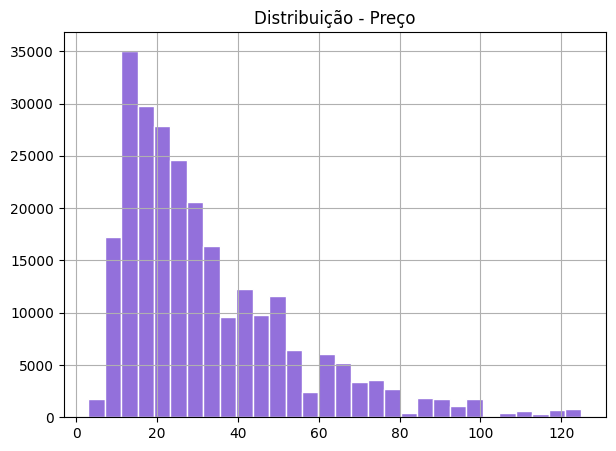

In [17]:
#Apaga do dataset as colunas que nao serao utilizadas
wine_reviews_reduced = wine_reviews.drop(columns=['wine','winery','designation',
                                                  'reviewer','review'])

#Filtra os outlier da coluna preco do dataset reduzido
filtered_price_wines = wine_reviews_reduced[wine_reviews['price'] <= 125]

#Verifica a distribuicao do preco dos vinhos
dist_price_wines = filtered_price_wines["price"].hist(bins=30,
                                                      figsize=(7, 5),
                                                      color='mediumpurple',
                                                      edgecolor='white')
plt.title("Distribuição - Preço")
plt.show()



- Análise da correlação entre as variáveis 'price' e 'category'.

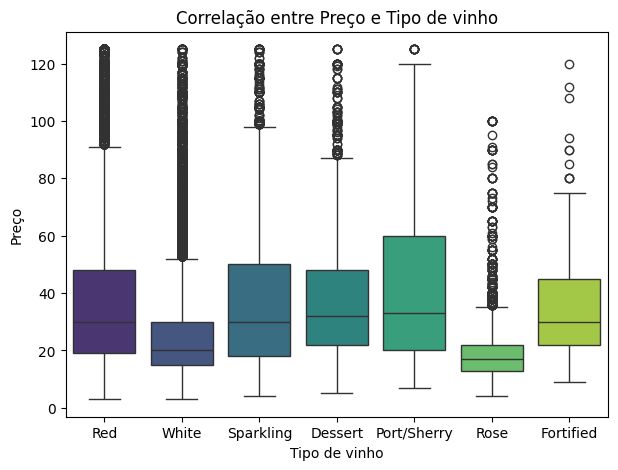

In [18]:
# === Correlação entre preço e o tipo de vinho ===

# Plota a relação Price x Category
plt.figure(figsize=(7,5))
graph = sns.boxplot(x='category', y='price', data=filtered_price_wines,
                    hue='category',palette='viridis')
graph.set_title("Correlação entre Preço e Tipo de vinho", fontsize=12)
graph.set_xlabel("Tipo de vinho", fontsize=10)
graph.set_ylabel("Preço", fontsize=10)
plt.show()


De acordo com o gráfico, podemos perceber que existe correlação entre o tipo de vinho ('category') e o preço. Por exemplo, vinhos Rosé possuem, em média, o preço menor que os demais vinhos como os do Porto e os tintos.

- Análise da correlação entre as variáveis 'price' e 'varietal'.

Para facilitar a análise, dos 848 tipos de uva, vamos selecionar os 30 tipos mais frequentes que correspondem à 82,8% do total.

In [19]:
num_registros_total = len(filtered_price_wines)
print(f"Número de registros total: {num_registros_total:,}".replace(',', '.'))

Número de registros total: 256.169


Número de registros do top 30: 212.064


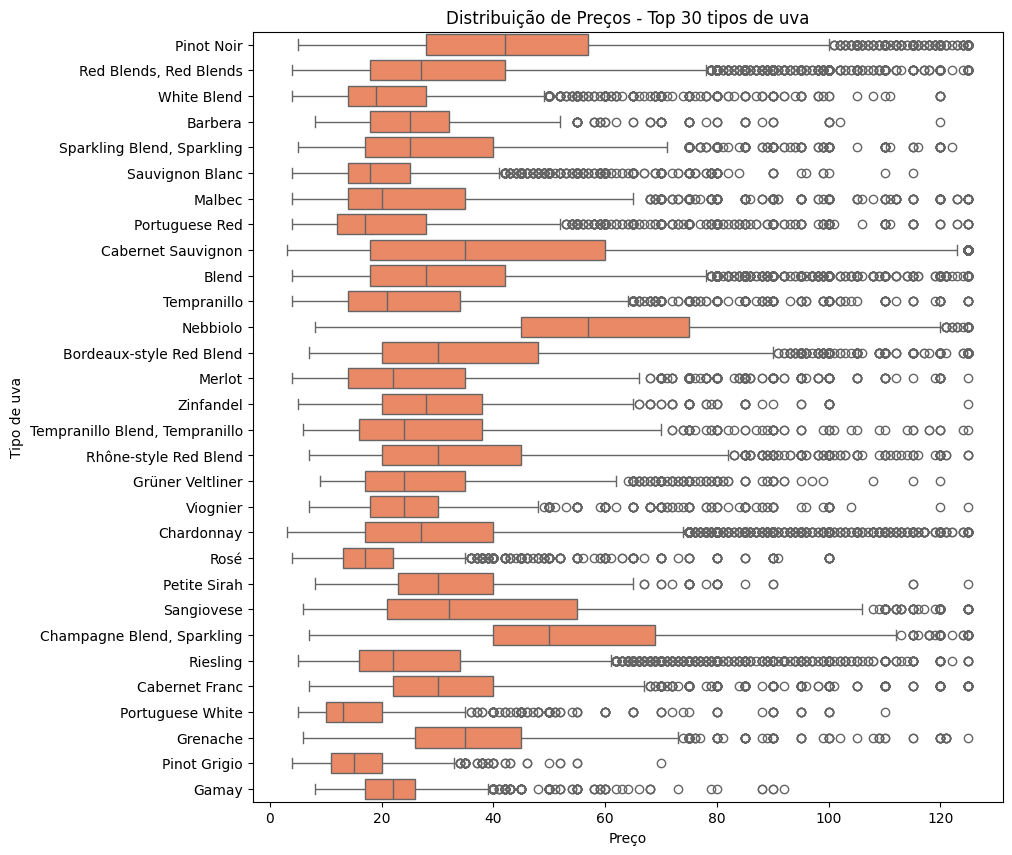

In [20]:
# === Correlação entre preço e tipo de uva ===

# Seleciona os 30 tipos de uva mais frequentes
top_30_varietal = filtered_price_wines['varietal'].value_counts().head(30).index
df_top30_varietal = filtered_price_wines[filtered_price_wines['varietal'].isin(top_30_varietal)]

num_registros = len(df_top30_varietal)
print(f"Número de registros do top 30: {num_registros:,}".replace(',', '.'))

# Plota a distribuição do preço dos top 30 tipos de uva
plt.figure(figsize=(15,10))
graph = sns.boxplot(x='price', y='varietal', data=df_top30_varietal,
                    color='coral')
graph.set_title("Distribuição de Preços - Top 30 tipos de uva", fontsize=12)
graph.set_xlabel("Preço", fontsize=10)
graph.set_ylabel("Tipo de uva", fontsize=10)
plt.subplots_adjust(left=0.4)
plt.show()

Podemos concluir que dependendo do tipo de uva escolhido o preço apresenta variação, evidenciando a correlação entre as variáveis.

- Análise da correlação entre as variáveis 'price' e 'alcohol'.

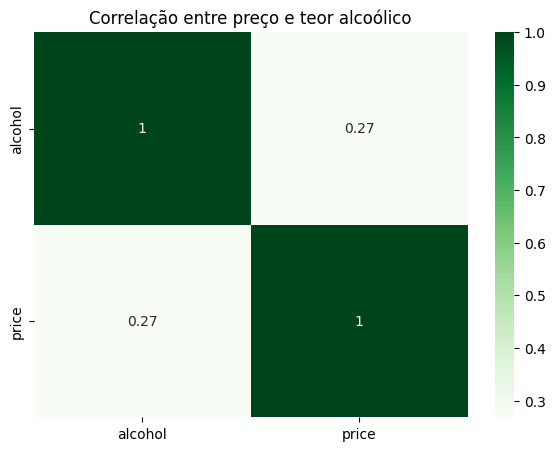

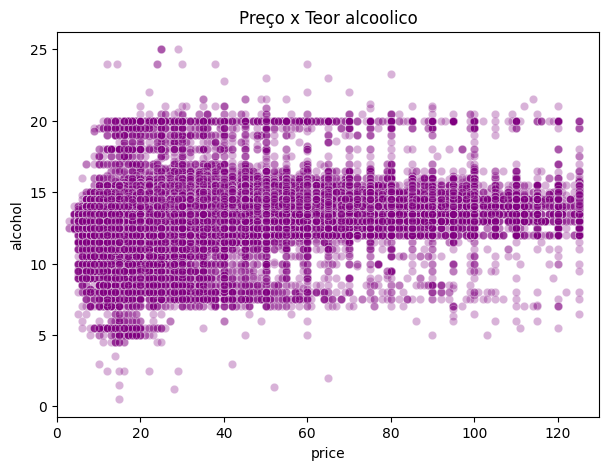

In [21]:
# ===Correlação entre preço e teor alcóolico ===

# Plota o mapa de calor do preço x teor alcoolico
plt.figure(figsize=(7,5))
sns.heatmap(filtered_price_wines[['alcohol','price']].corr(), annot=True,
            cmap='Greens')
plt.title('Correlação entre preço e teor alcoólico')
plt.show()

# Plota a relação preço x teor alcoolico
plt.figure(figsize=(7,5))
sns.scatterplot(data=filtered_price_wines, x='price', y='alcohol', alpha=0.3,
                color='purple')
plt.xlim(0, 130)
plt.title('Preço x Teor alcoolico')
plt.show()

Analisando os gráficos, concluímos que a correlação entre preço e teor alcoólico é baixa, ou seja, o teor alcoólico do vinho não influencia no seu preço.

- Análise da correlação entre as variáveis 'price' e 'rating_normalized'.

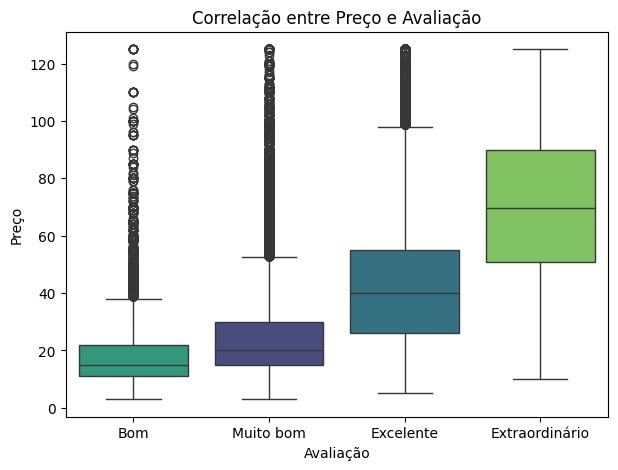

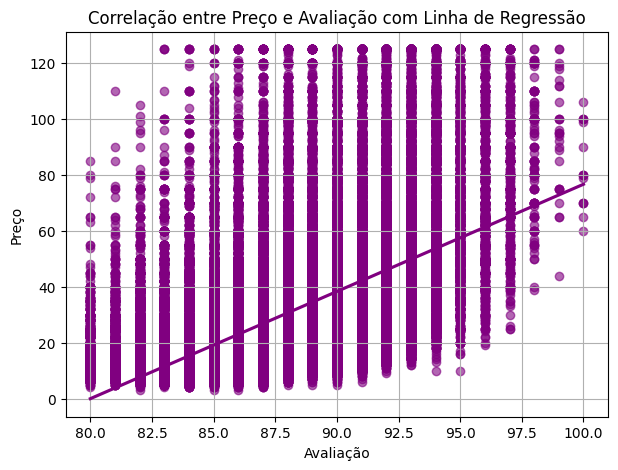

In [22]:
# === Correlacao entre preço e avaliação ===

# Plota a relação Preço x Avaliação
plt.figure(figsize=(7,5))
graph = sns.boxplot(x='rating_normalized', y='price',
                    data=filtered_price_wines,
                    hue='rating_normalized',
                    palette='viridis',
                    order=['Bom', 'Muito bom', 'Excelente', 'Extraordinário'])
graph.set_title("Correlação entre Preço e Avaliação", fontsize=12)
graph.set_xlabel("Avaliação", fontsize=10)
graph.set_ylabel("Preço", fontsize=10)
plt.show()

# Plota a relação Preço x Avaliação com linha de regressão
plt.figure(figsize=(7, 5))
sns.regplot(x='rating', y='price', data=filtered_price_wines, scatter_kws={'alpha':0.6}, color='purple')
plt.title('Correlação entre Preço e Avaliação com Linha de Regressão')
plt.xlabel('Avaliação')
plt.ylabel('Preço')
plt.grid(True)
plt.show()

Embora exista outliers em todas as faixas de avaliação, podemos verificar que existe uma relação linear entre avaliação e preço, ou seja, quanto melhor a faixa de avaliação maior é o preço.

- Análise da correlação entre as variáveis 'price' e 'appellation'.

A variável 'appellation' é uma Series onde o índice é a string "Sub-região, Região, País".
Para facilitar a análise, vamos selecionar as 30 regiões mais frequentes, pois estas correspondem à 82,2% do total.

In [23]:
#Contagem e separação das colunas
contagem = filtered_price_wines['appellation'].value_counts().reset_index()
contagem.columns = ['appellation', 'quantidade']
contagem[["subregiao", "regiao", "pais"]] = contagem["appellation"].apply(extrair_partes)

#Agrupa por regiao
agrupado_regiao = contagem.groupby('regiao')['quantidade'].sum().reset_index()

#Ordena da maior para a menor e seleciona as 30 primeiras regioes
agrupado_regiao = agrupado_regiao.sort_values(by="quantidade", ascending=False)
top_30_regiao = agrupado_regiao.head(30)
total_top30_regiao = top_30_regiao['quantidade'].sum()
print(f"\nTotal de registros das top 30 regiões: {total_top30_regiao:,}".replace(",", "."))
print(top_30_regiao)

#Agrupa por país
agrupado_pais = contagem.groupby('pais')['quantidade'].sum().reset_index()

#Ordena do maior para o menor e seleciona os 30 primeiros paises
agrupado_pais = agrupado_pais.sort_values(by="quantidade", ascending=False)

total_pais = agrupado_pais['quantidade'].sum()
print(f"\nTotal de registros dos paises: {total_pais:,}".replace(",", "."))
print(agrupado_pais)



Total de registros das top 30 regiões: 210.651
                   regiao  quantidade
99             California       78713
481            Washington       12494
330                Oregon       10722
445               Tuscany        9494
89               Bordeaux        8228
321        Northern Spain        7926
273      Mendoza Province        6729
351              Piedmont        6505
96               Burgundy        6067
313              New York        4791
450                Veneto        4785
61                 Alsace        4754
374          Rhône Valley        4626
402       South Australia        4571
319    Northeastern Italy        3923
249          Loire Valley        3885
394     Sicily & Sardinia        3582
123             Champagne        2785
405        Southern Italy        2734
406      Southwest France        2623
83             Beaujolais        2479
115         Central Italy        2479
361              Provence        2424
158                 Douro        2329
11

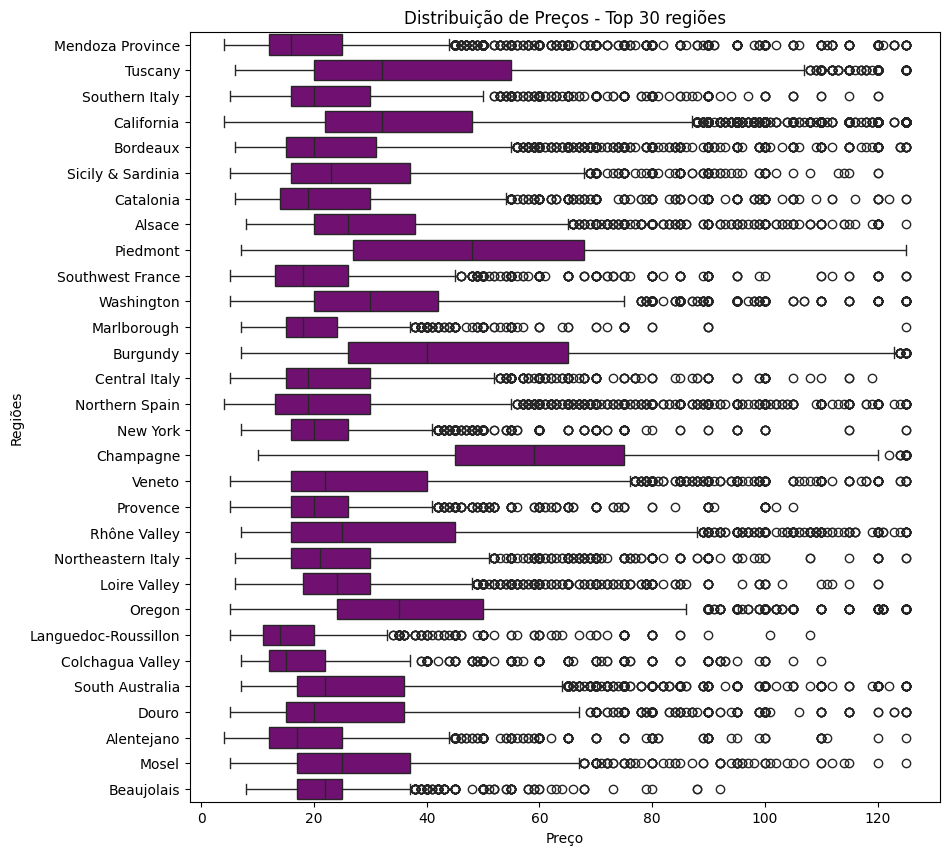

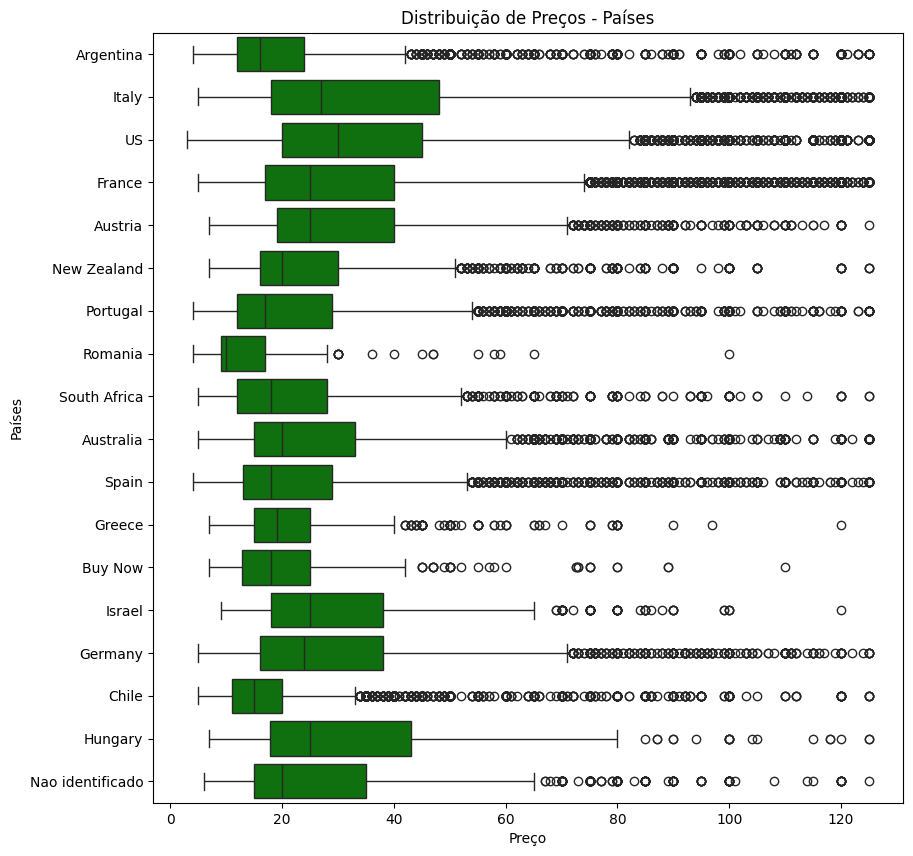

In [24]:
# === Correlação entre preço e a região de origem ===

df_price = filtered_price_wines.copy()
df_price[["subregiao", "regiao", "pais"]] = df_price["appellation"].apply(extrair_partes)
df_top30_price = df_price[df_price['regiao'].isin(top_30_regiao['regiao'])]

# Plota a distribuição do preço das top 30 regioes
plt.figure(figsize=(15,10))
graph = sns.boxplot(x='price', y='regiao', data=df_top30_price, color='purple')
graph.set_title("Distribuição de Preços - Top 30 regiões", fontsize=12)
graph.set_xlabel("Preço", fontsize=10)
graph.set_ylabel("Regiões", fontsize=10)
plt.subplots_adjust(left=0.4)
plt.show()

# Plota a distribuição do preço dos países
plt.figure(figsize=(15,10))
graph = sns.boxplot(x='price', y='pais', data=df_price, color='green')
graph.set_title("Distribuição de Preços - Países", fontsize=12)
graph.set_xlabel("Preço", fontsize=10)
graph.set_ylabel("Países", fontsize=10)
plt.subplots_adjust(left=0.4)
plt.show()

Podemos concluir que tanto a região quanto o país de origem se correlacionam com o preço do vinho. Dessa forma, adicionaremos as colunas região e país ao dataset que será utilizado para construção do modelo.

In [25]:
df_wines_final = filtered_price_wines.copy()

# Adiciona as variaveis "subregiao", "regiao", "pais"
df_wines_final[["subregiao", "regiao", "pais"]] = df_wines_final["appellation"].apply(extrair_partes)

# Retira a variáveis "alcohol", "appellation" e "subregiao" do dataset final
df_wines_final = df_wines_final.drop(columns=["alcohol","appellation","subregiao"])

display(df_wines_final.sample(5))
print("\nFormato:", df_wines_final.shape)
print("\nTipos:")
print(df_wines_final.dtypes)
print("\nValores ausentes por coluna:")
print(df_wines_final.isna().sum())

,category,varietal,price,rating,rating_normalized,regiao,pais
145323,Red,Petit Verdot,26.0,88,Muito bom,California,US
236862,Sparkling,"Sparkling Blend, Sparkling",15.0,85,Muito bom,Catalonia,Spain
265081,Sparkling,"Champagne Blend, Sparkling",40.0,89,Muito bom,Champagne,France
71379,White,Pinot Blanc,25.0,91,Excelente,Oregon,US
206087,White,"Viura, Spanish White",12.0,86,Muito bom,Northern Spain,Spain



Formato: (256169, 7)

Tipos:
category              object
varietal              object
price                float64
rating                 int64
rating_normalized     object
regiao                object
pais                  object
dtype: object

Valores ausentes por coluna:
category                0
varietal                0
price                   0
rating                  0
rating_normalized       0
regiao               2441
pais                    0
dtype: int64


Vamos finalizar a limpeza do dataset final com a retirada dos valores nulos da variável 'regiao', menos de 1% do total, e dos registros da variável 'pais' = "Buy Now', que é um erro no preenchimento da variável "appellation" e representa menos de 0,5% do total.

In [26]:
# Retira nulos de regiao
df_wines_final.dropna(subset=['regiao'], inplace=True)

#Retira pais = "Buy Now"
df_wines_final = df_wines_final[df_wines_final['pais'] != 'Buy Now']

display(df_wines_final.sample(5))
print("\nFormato:", df_wines_final.shape)
print("\nTipos:")
print(df_wines_final.dtypes)
print("\nValores ausentes por coluna:")
print(df_wines_final.isna().sum())

,category,varietal,price,rating,rating_normalized,regiao,pais
28148,Red,Rhône-style Red Blend,40.0,90,Excelente,Rhône Valley,France
171484,Red,"Red Blends, Red Blends",21.0,90,Excelente,Tuscany,Italy
64501,Red,Petite Sirah,32.0,91,Excelente,California,US
6054,Sparkling,"Sparkling Blend, Sparkling",15.0,87,Muito bom,California,US
202860,Red,"Red Blends, Red Blends",100.0,93,Excelente,California,US



Formato: (253180, 7)

Tipos:
category              object
varietal              object
price                float64
rating                 int64
rating_normalized     object
regiao                object
pais                  object
dtype: object

Valores ausentes por coluna:
category             0
varietal             0
price                0
rating               0
rating_normalized    0
regiao               0
pais                 0
dtype: int64



## 4. Definição do target, variáveis e divisão dos dados


O target definido previamente foi a variável 'price', mas devido a distribuição apresentada iremos utilizar o np.log1p(price) para deixá-la  mais estável.

In [27]:
# Seleciona o tipo de problema: 'classificacao' | 'regressao' | 'clusterizacao' | 'serie_temporal'
PROBLEM_TYPE = "regressao"
target = "price"
features = [c for c in df_wines_final.columns if c not in [target, "timestamp"]]

print("PROBLEM_TYPE:", PROBLEM_TYPE)
print("Target:", target)
print("N features:", len(features))

# Divisão dos dados
if PROBLEM_TYPE in ["classificacao", "regressao"]:
    X = df_wines_final[features].copy()
    y = np.log1p(df_wines_final[target]).copy() # Target (log-transform do preço para lidar com distribuição enviesada)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y if PROBLEM_TYPE=="classificacao" else None
    )
    print("Treino:", X_train.shape, "| Teste:", X_test.shape)

PROBLEM_TYPE: regressao
Target: price
N features: 6
Treino: (202544, 6) | Teste: (50636, 6)



## 5. Tratamento de dados e **Pipeline** de pré-processamento


Para lidar com as variáveis categóricas fizemos o pré-processamento utilizando OneHot Enconder para obter uma representação numérica binária desses dados.

In [28]:
num_cols = [c for c in X_train.columns if str(X_train[c].dtype).startswith(("float","int"))]
cat_cols = [c for c in X_train.columns if c not in num_cols and c != "timestamp"]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore",max_categories=50))
    ])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])


print("num_cols:", num_cols[:5], "...")
print("cat_cols:", cat_cols[:5], "...")

num_cols: ['rating'] ...
cat_cols: ['category', 'varietal', 'rating_normalized', 'regiao', 'pais'] ...



## 6. Baseline e modelos candidatos
Para o baseline utilizamos o modelo DummyRegressor e modelos candidatos são
os algoritmos regressão linear, regressão linear com regularização Ridge, regressão linear com regularização Lasso, RandomForest e LightGBM.


In [35]:
# === Baselines ===
if  PROBLEM_TYPE == "regressao":
    baseline = Pipeline(steps=[("pre", preprocess),
                               ("model", DummyRegressor(strategy="median"))])
    candidates = {

        "LinearRegression": Pipeline([("pre", preprocess), ("model", LinearRegression())]),
        "Ridge": Pipeline([("pre", preprocess), ("model", Ridge(random_state=SEED))]),
        "Lasso": Pipeline([("pre", preprocess), ("model", Lasso(random_state=SEED))]),
        "RandomForestReg": Pipeline([("pre", preprocess), ("model", RandomForestRegressor(random_state=SEED))]),
        "LightGBM": Pipeline([("pre", preprocess), ("model", LGBMRegressor(random_state=SEED))])
    }
else:
    raise ValueError("PROBLEM_TYPE inválido.")

baseline

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['rating']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 max_categories=50))]),
                                                  ['category', 'varietal',
                                                   'rating_normalized',
                                                   'regiao', 'pais'])])),
                ('model', DummyRegressor(strategy='median'))])


### 6.1 Treino e avaliação rápida (baseline vs candidatos)
Fizemos o treino inicial do baseline e modelos candidatos.


In [36]:
results = {}

# Baseline
t0 = time.time()
baseline.fit(X_train, y_train)
t1 = time.time()
y_pred = baseline.predict(X_test)
results["baseline"] = evaluate_regression(y_test, y_pred)
results["baseline"]["train_time_s"] = round(t1 - t0, 3)

# Candidatos
for name, pipe in candidates.items():
  t0 = time.time()
  pipe.fit(X_train, y_train)
  t1 = time.time()
  y_pred_c = pipe.predict(X_test)
  results[name] = evaluate_regression(y_test, y_pred_c)
  results[name]["train_time_s"] = round(t1 - t0, 3)

pd.DataFrame(results).T

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 276
[LightGBM] [Info] Number of data points in the train set: 202544, number of used features: 128
[LightGBM] [Info] Start training from score 3.334297


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,MAE,RMSE,R²,train_time_s
baseline,0.484921,0.593913,-0.016110,3.271
LinearRegression,0.315002,0.399898,0.539327,2.979
Ridge,0.315003,0.399899,0.539324,2.446
Lasso,0.487211,0.589188,-0.000006,2.277
RandomForestReg,0.295965,0.382633,0.578246,714.192
LightGBM,0.298415,0.383004,0.577427,3.642


Da avaliação inicial, percebemos que o RandomForestReg e o LightGBM apresentam os melhores resultados. De uma forma geral, estes modelos apresentam melhores resultados para datasets grandes e com dados tabulares quando comparamos com os demais modelos. Com relação ao resultado em si, o valor de R² = 0.58 é considerado satisfatório, pois em problemas de preços de vinhos, R² entre 0.5 e 0.8 já é bom dado que o preço depende de fatores não descritos nesse dataset como nome do vinho e vinícula.


## 7. Validação e Otimização de Hiperparâmetros
Fizemos a validação cruzada usando KFold dos modelos que apresentaram as melhores métricas de avaliação.


In [44]:
# Scorer corrigido para RMSE (negativo, pois sklearn maximiza score)
rmse_scorer = make_scorer(lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred)))

scoring = {
    "MAE": "neg_mean_absolute_error",
    "RMSE": rmse_scorer,
    "R2": "r2"
}

# Modelos que vamos comparar
models = {
    "RandomForest": RandomForestRegressor(random_state=SEED),
    "LightGBM": LGBMRegressor(random_state=SEED)
}

# Resultados finais
results = []
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
for name, model in models.items():
  pipe = Pipeline(steps=[("pre", preprocess), ("model", model)])
  cv_results = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring)
  results.append({
      "Modelo": name,
      "X_train": X_train,
      "y_train": y_train,

      # MAE
      "MAE_mean": -cv_results["test_MAE"].mean(),
      "MAE_std":  cv_results["test_MAE"].std(),

      # RMSE
      "RMSE_mean": -cv_results["test_RMSE"].mean(),
      "RMSE_std":  cv_results["test_RMSE"].std(),

      # R²
      "R2_mean": cv_results["test_R2"].mean(),
      "R2_std":  cv_results["test_R2"].std()
      })

df_results = pd.DataFrame(results)
print(df_results.sort_values(by=["MAE_mean"]))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 276
[LightGBM] [Info] Number of data points in the train set: 162035, number of used features: 128
[LightGBM] [Info] Start training from score 3.334276


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 276
[LightGBM] [Info] Number of data points in the train set: 162035, number of used features: 128
[LightGBM] [Info] Start training from score 3.334631


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 276
[LightGBM] [Info] Number of data points in the train set: 162035, number of used features: 128
[LightGBM] [Info] Start training from score 3.333841


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 276
[LightGBM] [Info] Number of data points in the train set: 162035, number of used features: 128
[LightGBM] [Info] Start training from score 3.333926


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 276
[LightGBM] [Info] Number of data points in the train set: 162036, number of used features: 128
[LightGBM] [Info] Start training from score 3.334809


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


         Modelo  MAE_mean   MAE_std  RMSE_mean  RMSE_std   R2_mean    R2_std
0  RandomForest  0.297306  0.000855   0.385023  0.000763  0.572826  0.003403
1      LightGBM  0.298673  0.000884   0.384099  0.000706  0.574878  0.003044


O tuning do modelo LightGBM foi feito usando RandomizedSearchCV, pois este tem melhor desempenho para dataset grandes quando comparado ao GridSearchCV.

In [46]:
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
model = Pipeline([("pre", preprocess), ("model", LGBMRegressor(random_state=SEED))])
param_dist = {
            "model__n_estimators": randint(200, 1000),
            "model__learning_rate": uniform(0.01, 0.2),
            "model__max_depth": randint(3, 15),
            "model__num_leaves": randint(20, 200),
            "model__subsample": uniform(0.6, 0.4),
            "model__colsample_bytree": uniform(0.6, 0.4)
    }
scorer = "r2"

search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=cv, scoring=scorer, random_state=SEED, n_jobs=-1, verbose=1)
search.fit(X_train, y_train)
print("Melhor score (CV):", search.best_score_)
print("Melhores parâmetros:", search.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 276
[LightGBM] [Info] Number of data points in the train set: 202544, number of used features: 128
[LightGBM] [Info] Start training from score 3.334297
Melhor score (CV): 0.5850691684494381
Melhores parâmetros: {'model__colsample_bytree': np.float64(0.6092249700165663), 'model__learning_rate': np.float64(0.11495493205167782), 'model__max_depth': 12, 'model__n_estimators': 675, 'model__num_leaves': 34, 'model__subsample': np.float64(0.7824279936868144)}


Após a execução da validação cruzada, obtivemos os parâmetros para a nova execução do Modelo LightGBM.

Além disso, devido ao tempo necessário para a execução o resultado foi salvo em um arquivo PKL: LGBM_Otimizado.pkl

In [47]:
# Salva o resultado
resultado_salvar = {
    "modelo": "LightGBM",
    "melhores_parametros": search.best_params_,
    "X_test": X_test,
    "y_test": y_test,
    "X_train": X_train,
    "y_train": y_train
}
filename = f"LGBM_Otimizado.pkl"
joblib.dump(resultado_salvar, filename)

['LGBM_Otimizado.pkl']


## 8. Avaliação final, análise de erros e limitações

Nesta etapa re-treinamos o modelo com base nos parâmetros obtidos a partir da validação cruzada e na sequência avaliamos os resultados.

In [48]:
# Carrega o resultado do modelo treinado e otimizado

dados = joblib.load("LGBM_Otimizado.pkl")
modelo_carregado = dados["modelo"]
X_test = dados["X_test"]
y_test = dados["y_test"]
X_train = dados["X_train"]
y_train = dados["y_train"]


In [49]:
# Re-treino no conjunto de treino+validação e avaliação no teste

if PROBLEM_TYPE in ["classificacao", "regressao"] and 'search' in globals() and hasattr(search, "best_estimator_"):
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    if PROBLEM_TYPE == "classificacao":
        from sklearn.metrics import classification_report, ConfusionMatrixDisplay
        print(classification_report(y_test, y_pred))
        try:
            ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
            plt.title("Matriz de confusão - Melhor modelo")
            plt.show()
        except Exception as e:
            print("Não foi possível plotar a matriz de confusão:", e)
    else:
        print('Metricas para avaliar a regressão: ', evaluate_regression(y_test, y_pred))
elif PROBLEM_TYPE == "clusterizacao":
    print("Realize análise qualitativa/negócio dos clusters. Visualize centros e perfis.")
elif PROBLEM_TYPE == "serie_temporal":
    print("Avalie métricas fora do tempo; plote série real vs prevista.")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Metricas para avaliar a regressão:  {'MAE': 0.2928844766772354, 'RMSE': np.float64(0.3778994652497562), 'R²': 0.5886163598189853}


Os resultados foram ligeiramente melhores do que os resultados obtidos inicialmente.

R2 Baseline: 0.574878 vs R2 Otimizado: 0.588616

RMSE Baseline: 0.383004 vs RMSE Otimizado: 0.377899

Na sequência, comparamos alguns resultados obtidos a partir das previsões:

In [50]:
# Compara os preços reais vs previstos (em escala original)
results = pd.DataFrame({
    "real_price": np.expm1(y_test),      # inverso do log1p
    "predicted_price": np.expm1(y_pred)
})


print(results.head(10))

        real_price  predicted_price
210979        17.0        27.388601
245110        20.0        15.222129
230020        16.0        19.173660
143706        25.0        16.435262
72763         25.0        21.539759
228021        42.0        43.675495
159018        21.0        20.947564
65018         17.0        23.197694
64674         28.0        24.230344
238053        35.0        25.026737


Conforme podemos observar o modelo não tem uma acurâcia muito grande o que é explicado pelo valor baixo de R2 (0,58). Isso significa que apenas 58% da varíavel alvo é explicado pelas features escolhidas.


## 9. Conclusões e próximos passos

Foi desenvolvido um modelo de aprendizado de máquina para prever o preço de vinhos com base nas variáveis: rating, category, varietal, rating_normalized, regiao e pais.

O modelo que apresentou melhor desempenho foi o LightGBM, configurado com parâmetros otimizados para o problema. As métricas de avaliação no conjunto de teste foram:

MAE (Erro Absoluto Médio): 0,293

RMSE (Raiz do Erro Quadrático Médio): 0,378

R² (Coeficiente de Determinação): 0,589

Esses resultados indicam que o modelo consegue capturar cerca de 59% da variabilidade do preço dos vinhos com base nas features selecionadas. Embora o modelo apresente bom desempenho, ainda há espaço para melhorias, especialmente considerando a complexidade e a variabilidade dos preços de vinhos.

Trade-offs e Considerações:

O MAE relativamente baixo indica que, em média, as previsões estão próximas dos valores reais, o que é importante para aplicações práticas.

O RMSE, ligeiramente maior que o MAE, sugere que existem alguns erros maiores que impactam a média quadrática, possivelmente devido a outliers ou vinhos de preços muito altos.

O R² abaixo de 0,6 mostra que parte significativa da variabilidade não é explicada pelas features atuais, sugerindo que fatores adicionais podem ser relevantes.

Possíveis Melhorias Futuras:

Incorporação de novas features: incluir características como safra (vintage), pontuações de críticos específicos, tipo de uva detalhado, avaliações sensoriais e até indicadores econômicos regionais.

Aumento de dados: utilizar datasets adicionais para melhorar a cobertura de regiões, categorias e variedades, reduzindo o viés e aumentando a robustez do modelo.

Engenharia de features: explorar interações entre variáveis, codificações mais sofisticadas para variáveis categóricas, transformações logarítmicas de preços e normalizações adicionais.

Tuning e validação: realizar otimização de hiperparâmetros mais refinada (por exemplo, usando Optuna ou Bayesian Optimization) e técnicas de ensemble com múltiplos modelos (Random Forest, CatBoost, XGBoost) para capturar diferentes padrões do dataset.

Análise de outliers e segmentação: tratar vinhos de preços extremos separadamente ou criar modelos específicos por categoria/região para reduzir impacto de valores atípicos.

Em resumo, o modelo atual oferece uma boa base preditiva, mas há oportunidades claras de melhoria por meio de features adicionais, maior volume de dados e técnicas avançadas de modelagem, que podem elevar a performance e a precisão das previsões de preço.
